This script produces quantile-quantile plots comparing various kinds of data:
- across events in NERC GIC data
- across NERC GIC and QDC GIC data
- ...


In [ ]:
 statsmodels.graphics.gofplots.qqplot_2samples(data1, data2, xlabel=None, ylabel=None, line=None, ax=None)[source]
pp_x = sm.ProbPlot(x)
pp_y = sm.ProbPlot(y)
qqplot_2samples(pp_x, pp_y)
plt.show()

# Imports

In [13]:
import numpy as np
import pandas as pd
import glob
import os

import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot_2samples
import pylab

import datetime
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec


from sunpy.net import Fido
from sunpy.net import attrs as a
from sunpy.timeseries import TimeSeries



# Functions

In [8]:
# Note that these functions were copied from NERC_data_complexity.ipynb on November 27, 2023 and should be copied periodically as it is maintained there

def clean_GIC_data(df,df_sensor_locations,threshold):
    '''
    - delete repeated time points
    - delete station if all time points are empty
    - Find how many of the measurements differ from one time step to the next and delete station if on average measurements differ less than once in 5 minutes
    - remove repeat stations from files
    - remove stations with an unacceptable level of bias
    
    '''
    
    # Delete repeated time points
    df = df.drop(df[df.duplicated(subset='datetimes', keep='first')].index)
    
    cols_to_drop = []
    for id_loop in df.columns.to_list():
        
        if (id_loop == 'datetimes'):
            continue
            
        # Delete station if most time points are empty
        if ( (df[id_loop].isna().mean() * 100) > 80.):
            cols_to_drop.append(id_loop)
            continue
            
    print('cols_to_drop after first filter = {}'.format(cols_to_drop))

    # remove repeat stations from files
    duplicate_lats = df_sensor_locations.duplicated(subset=' Latitude',keep='first')
    duplicate_lons = df_sensor_locations.duplicated(subset=' Longitude',keep='first')
    duplicate_locations = df_sensor_locations['Device ID'].values[np.where( (duplicate_lats.values==True) & (duplicate_lons.values==True) )]

    for d in duplicate_locations:
        try:
            #print(df[str(d)])
            cols_to_drop.append(str(d))
        except:
            print('no df entry for devide ID {}'.format(str(d)))
#         # Check I wrote to guarantee the code above removes duplicate stations (keeping only one of the same lat-long)
#         for a in df_sensor_locations['Device ID'].values[np.where( (duplicate_lats.values==True) & (duplicate_lons.values==True) )]:
#             idx = df_sensor_locations.index[df_sensor_locations['Device ID'] == a].tolist()
#             print('the index of the duplicated lat and lon = {}'.format(a))
#             print(' \t --> {}'.format( df_sensor_locations[idx[0]-2:idx[0]+3] ))

    print('cols_to_drop after second filter = {}'.format(cols_to_drop))

    # Find how many of the measurements differ from one time step to the next and delete station if measurements repeat for more than 60% of the data 
    for device_id in df.columns.to_list():
        if device_id == 'datetimes':
            continue
        count_zeros = np.count_nonzero(np.diff(df[device_id].values) == 0)
        tmp_len = len(np.argwhere(np.isfinite(df[device_id].values)==True))
        tmp = (count_zeros/tmp_len)*100
#             print('percentage of repeated values = {}'.format( tmp  ))
        if tmp > 60.:
            cols_to_drop.append(device_id)

    print('cols_to_drop after third filter = {}'.format(cols_to_drop))
    
    
    
    # Catch bias that is near the threshold level (would cause issues with burst statistics)
    for device_id in df.columns.to_list():
        if device_id == 'datetimes':
            continue
        med_tmp = np.nanmedian(df[device_id].values)
        # apply conservative value for an unacceptable level of bias 
        if abs(med_tmp) >= (threshold/2):
            cols_to_drop.append(device_id)
            
    print('cols_to_drop after fourth filter = {}'.format(cols_to_drop))



    cols_to_drop = list(set(cols_to_drop))
    print('Total number of columns to drop = {}'.format(len(cols_to_drop)))
#     # some stations were removed in the process of creating the integrated data files, so need to check if all columns to remove exist
    cols_to_drop_final = []
    for c in cols_to_drop:
        if any( str(c) in x for x in df.columns.to_list()):
            cols_to_drop_final.append(str(c))
        else:
            print('{} is NOT in the columns list'.format(c))

    df = df.drop(cols_to_drop_final,axis=1)
    
    return df


def get_sw_one_minute(start_datetime,end_datetime):

    '''
    input datetimes must be in format '%Y/%m/%d %H:%M:%S'
    '''
    

#     sunpy_format = '%Y/%m/%d %H:%M'

#     trange = a.Time(start_datetime.strftime(sunpy_format), end_datetime.strftime(sunpy_format))
    trange = a.Time(start_datetime,end_datetime)
    dataset = a.cdaweb.Dataset('OMNI_HRO2_1MIN')
    result = Fido.search(trange, dataset)

    downloaded_files = Fido.fetch(result[0])
    print(downloaded_files)
    
    sw_data = TimeSeries(downloaded_files, concatenate=True)
    df_SW = sw_data.to_dataframe()
    df_SW['datetimes'] = df_SW.index
    strings_to_match = ['AE_INDEX','BX_GSE','BY_GSM','BZ_GSM']
    filtered_columns = df_SW.filter(items=strings_to_match, axis=1)
    df_SW_filtered = df_SW.drop(columns=df_SW.columns.difference(strings_to_match))

    print(df_SW_filtered.columns)
    datetimes_SW = [t.strftime('%Y/%m/%d %H:%M:%S') for t in df_SW_filtered.index]
    df_SW_filtered['datetimes'] = datetimes_SW



    return df_SW_filtered
    
    


# File directories


In [9]:
qdc_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/'

nerc_directory = '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/'



# Q-Q Analyses

## QDC vs NERC

In [10]:
# read in QDC data for some station and solar wind variables

qdc_data_dir = qdc_directory
qdc_files = glob.glob( os.path.join(qdc_data_dir,'*.csv') )
qdc_files




['/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_1_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_2_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_3_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_6_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_7_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_5_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv',
 '/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resamp

In [15]:

for f in qdc_files[0:1]:

        
    df_QDC = pd.read_csv(f,index_col=False)

    print('\n\n\n\n----------------------------\nworking on node: {}'.format(f[84:90])) #f.find('event')
    print('\t--->{}'.format(f))

    # only need to do the solar wind calculation once
    if f[84:90] == 'Node_1':
        # Calculate solar wind variables, starting by getting one minute values
        df_SW_oneminute_QDC = get_sw_one_minute(df_QDC['DateTime'].values[0],df_QDC['DateTime'].values[-1])
        df_SW_oneminute_QDC['IMF magnitude'] = np.sqrt( df_SW_oneminute_QDC['BX_GSE']**2 + df_SW_oneminute_QDC['BY_GSM']**2 + df_SW_oneminute['BZ_GSM']**2 )








----------------------------
working on node: Node_1
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/QDC_data/resampled/Node_1_anon_gic_qdc_median_wdy10_wmin1800_fm3_wgic_resampled.csv


Files Downloaded:   0%|          | 0/14 [00:00<?, ?file/s]

['/Users/ryanmc/sunpy/data/omni_hro2_1min_20180801_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20180901_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20181001_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20181101_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20181201_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190101_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190201_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190301_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190401_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190501_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190601_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190701_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190801_v01.cdf', '/Users/ryanmc/sunpy/data/omni_hro2_1min_20190901_v01.cdf']


Index(['AE_INDEX', 'BX_GSE', 'BY_GSM', 'BZ_GSM'], dtype='object')


NameError: name 'df_SW_oneminute' is not defined

In [26]:
# read in NERC data for some event and solar wind variables

nerc_files = glob.glob( os.path.join(nerc_directory,'*.csv') )
nerc_files

threshold_cleanGIC = 0.5


for f in nerc_files[9:10]:
    df_NERC = pd.read_csv(f,index_col=False)
    df_NERC = df_NERC.drop(columns='Unnamed: 0')

    # read in the lat-long values for the sensors in this event
    print('\n\n\n\n----------------------------\nworking on event: {}'.format(f[97:-4])) #f.find('event')
    print('\t--->{}'.format(f))
    file_sensor_locations = os.path.join('/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/','risk-resiliency-spwx','data',f[97:-4],'GIC','gic_monitors.csv')

    print('\t--->{}'.format(file_sensor_locations))
    df_sensor_locations = pd.read_csv(file_sensor_locations)

    # Drop unwanted columns, but save IMF and AE index columns
#     df_SW = df(['datetimes','AE_INDEX','BX_GSE','BY_GSM','BZ_GSM']).copy()
    cols_to_drop_loc = df_NERC.columns.get_loc('AE_INDEX')
    df_NERC.columns.to_list()[cols_to_drop_loc:]
    df_NERC = df_NERC.drop(df_NERC.columns.to_list()[cols_to_drop_loc:],axis = 1)

    # Calculate solar wind variables, starting by getting one minute values
    df_SW_oneminute_NERC = get_sw_one_minute(df_NERC['datetimes'].values[0],df_NERC['datetimes'].values[-1])
    df_SW_oneminute_NERC['IMF magnitude'] = np.sqrt( df_SW_oneminute_NERC['BX_GSE']**2 + df_SW_oneminute_NERC['BY_GSM']**2 + df_SW_oneminute_NERC['BZ_GSM']**2 )


#     # Clean the data
#     df_NERC = clean_GIC_data(df_NERC,df_sensor_locations,threshold_cleanGIC)
        
        
        





----------------------------
working on event: event_20180825
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/integrated_data/integrated_data_event_20180825.csv
	--->/Users/ryanmc/Documents/Conferences/Jack_Eddy_Symposium_2022/dev/risk-resiliency-spwx/data/event_20180825/GIC/gic_monitors.csv


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

['/Users/ryanmc/sunpy/data/omni_hro2_1min_20180801_v01.cdf']


Index(['AE_INDEX', 'BX_GSE', 'BY_GSM', 'BZ_GSM'], dtype='object')


In [32]:
df_NERC[]

,datetimes,10095,10081,10297,10254,10485,10491,10320,10452,10321,...,10264,10258,10489,10113,10107,10305,10488,10259,10271,10067
1,2018-08-25 00:00:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-08-25 00:00:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-08-25 00:00:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-08-25 00:00:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2018-08-25 00:00:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125894,2018-08-28 23:59:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125895,2018-08-28 23:59:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125896,2018-08-28 23:59:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
125897,2018-08-28 23:59:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [33]:
NERC_stacked = df_NERC.iloc[:,1:].stack().values


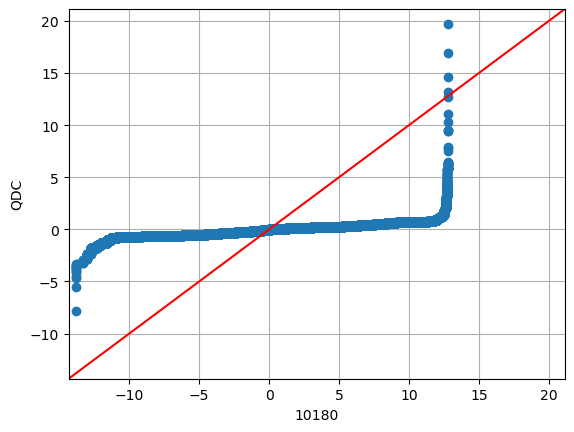

In [35]:
# NERC_station_ID = '10180'
pp_x = sm.ProbPlot(df_QDC['GIC'].values)
pp_y = sm.ProbPlot(NERC_stacked)
# qqplot_2samples(pp_x, pp_y,xlabel='QDC',ylabel=NERC_station_ID,line="45")
qqplot_2samples(pp_x, pp_y,xlabel='QDC',ylabel=NERC_station_ID,line="45")
plt.grid(True)
plt.show()

,AE_INDEX,BX_GSE,BY_GSM,BZ_GSM,datetimes,IMF magnitude
Epoch,,,,,,
2018-08-01 00:00:00,203,2.63,1.90,-3.90,2018/08/01 00:00:00,5.073155
2018-08-01 00:01:00,196,2.53,2.16,-4.11,2018/08/01 00:01:00,5.287590
2018-08-01 00:02:00,195,2.26,2.41,-3.59,2018/08/01 00:02:00,4.878914
2018-08-01 00:03:00,205,2.31,2.44,-3.50,2018/08/01 00:03:00,4.851773
2018-08-01 00:04:00,207,2.17,2.56,-3.35,2018/08/01 00:04:00,4.741835
...,...,...,...,...,...,...
2018-08-31 23:55:00,32,-4.90,-1.74,1.35,2018/08/31 23:55:00,5.372159
2018-08-31 23:56:00,31,-4.91,-1.73,1.34,2018/08/31 23:56:00,5.375556
2018-08-31 23:57:00,28,-4.88,-1.79,1.45,2018/08/31 23:57:00,5.396388


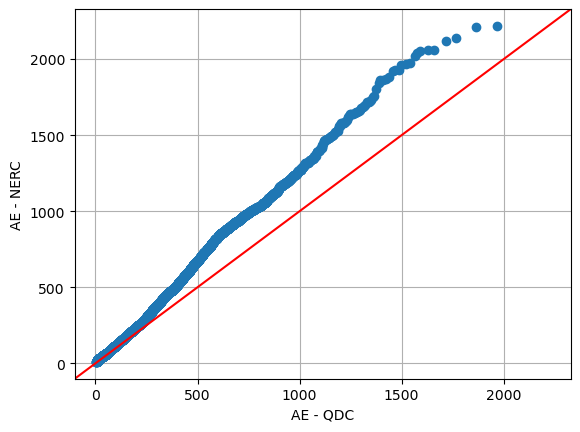

In [40]:
pp_x = sm.ProbPlot(df_SW_oneminute_QDC['AE_INDEX'][df_SW_oneminute_QDC['AE_INDEX']<9900].values)
pp_y = sm.ProbPlot(df_SW_oneminute_NERC['AE_INDEX'][df_SW_oneminute_QDC['AE_INDEX']<9900].values)
# qqplot_2samples(pp_x, pp_y,xlabel='QDC',ylabel=NERC_station_ID,line="45")
qqplot_2samples(pp_x, pp_y,xlabel='AE - QDC',ylabel='AE - NERC',line="45")
plt.grid(True)
plt.show()